# AskReddit Post Generator by Yoonbo Cho
Askreddit is a subreddit on a popular website called Reddit where people post interesting, funny, or serious questions that others can answer. I performed two experiments from collecting my own web scrapped data:

1. Classify a AskReddit Post to predict how well the question will perform
2. Generate a AskReddiit Post that will perform well

## Table of Contents
1. Data Collection
2. Data Exploration
3. Data Analysis
4. Feature Engineering
5. Classification Model
6. Generation Model

## The Question and Mission
The Questions from data analysis:
1. What is the best day of the week to post a Askreddit question?
2. What are the most popular words that are used in the posts with the highest upvotes?

The Mission of this experiment:
1. Train a Generation Model and Generate n number of Askreddit Questions using Askreddit data with the highest upvotes.
2. Train a Classification Model and Classify the generated Askreddit Questions and choose the best one.
3. Create a Bot to periodically post the best Askreddit Question on Reddit using the best time and day of the week


## 1. Data Collection
One of the most challening part of this experiment was collecting and cleaning the data. I used a python library called BeauitfulSoup to webscrape the data and created functions to clean and transfer the data to a .csv file. You can take a look at the code here:

Github Location

For the Askreddit Bot I used Reddit Api to collect data. Because Reddit Api has a limit of 100 rows of data, using Web Scraping I am able to collect more data per use. At the same time  the pros of Reddit Api is that it uses less computation creating a more optimal bot.

Now, 
let's import the nesscary files for this experiment as well as the dataset.

In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical

import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from textwrap import wrap

%matplotlib inline

I webscraped both the month's top posts and today's top posts but will be focusing more on the month. The amount of data(51) in "today's" posts is quite small but will be used to determine the popularity and highest upvote and comment from time of the day.

In [14]:
# import the dataset
month = "https://raw.githubusercontent.com/ProHanzo/AskReddit/master/askreddit_data_month.csv"
df = pd.read_csv(month)
df.head()

,Title,Upvotes,DayofWeek,# of Comments
0,It's more than likely that Covid-19 will still...,137000,3,15400
1,How would you feel if the U.S. government made...,102000,1,10700
2,What do you KNOW is true without evidence? Wha...,98000,1,52100
3,What's your favorite poverty meal that you sti...,94000,6,40400
4,"If you got offered $1,000,000 but it meant tha...",91000,2,15000


## 2. Data Exploration
This dataset consist of a month worth of askreddit posts from highest to lowest ratings. Although the dataset is not too large(1203 rows) this is actually beneficial for the generation model. The reason sticking to a smaller timeframe is beneficial is because popular topics change with the climate. So last month oranges could be viral, this month apples.

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1203 entries, 0 to 1202
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Title          1203 non-null   object
 1   Upvotes        1203 non-null   int64 
 2   DayofWeek      1203 non-null   int64 
 3   # of Comments  1203 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 37.7+ KB


- "Title" - The AskReddit post's question.
- "Upvotes" - Upvotes are Reddit's indication of likes or points, the higher the better.
- "DayofWeek" - The day of the week as an integer, where Monday is 0 and Sunday is 6.
- "# of Comments" - Number of comments the post got.


In [16]:
df.isnull().sum()

Title            0
Upvotes          0
DayofWeek        0
# of Comments    0
dtype: int64

In [17]:
df.describe()

,Upvotes,DayofWeek,# of Comments
count,1203.000000,1203.000000,1203.000000
mean,10035.947631,2.940150,3800.465503
std,20222.301371,1.985742,6954.385719
min,224.000000,0.000000,3.000000
25%,407.500000,1.000000,637.000000
50%,1000.000000,3.000000,1300.000000
75%,7000.000000,5.000000,3200.000000
max,137000.000000,6.000000,59600.000000


In [18]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,Upvotes,DayofWeek,# of Comments
Upvotes,1.000000,0.005164,0.804206
DayofWeek,0.005164,1.000000,-0.008414
# of Comments,0.804206,-0.008414,1.000000


## 3. Data Analysis


### 3.1 Title

In [19]:
# The most popular First word from the sentence
df['First_Word'] = df['Title'].str.split().str[0]
df['First_Word'].value_counts().nlargest(10)

What         437
If            78
What's        69
What’s        62
People        56
You           44
[Serious]     43
How           40
Which         29
Men           18
Name: First_Word, dtype: int64

In [20]:
# Average amount of words per sentence
df["Title"].str.split().str.len().mean()

13.291770573566085

In [21]:
# Create a copy for analysis
df["Title_Analysis"] = df["Title"]

# Remove punctuations
df["Title_Analysis"] = df['Title_Analysis'].str.replace('[^\w\s]','')

# All lower case
df['Title_Analysis'] = df['Title_Analysis'].str.lower()

# Remove stop words
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
df['Title_Analysis'] = df['Title_Analysis'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

df.Title_Analysis.str.split(expand=True).stack().value_counts()

whats         200
people        137
reddit        135
thing         101
one            69
             ... 
close           1
hyperreal       1
norwegians      1
contacts        1
changing        1
Length: 2130, dtype: int64

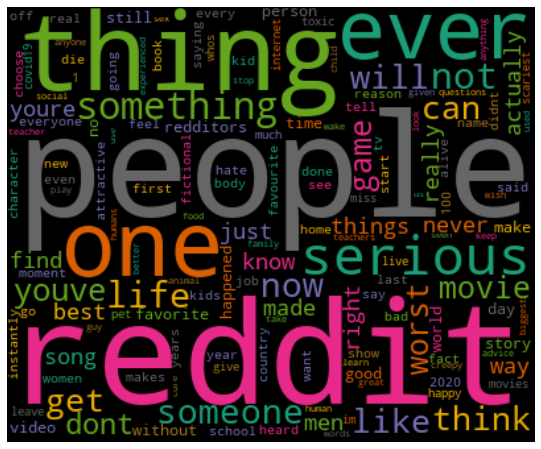

In [22]:
# Create a word cloud to visualize the popularity of words
title_ = df.Title_Analysis.str.split(expand=True).stack().value_counts()
title_ = title_[1:]

wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate_from_frequencies(title_)
plt.figure(figsize=(10,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

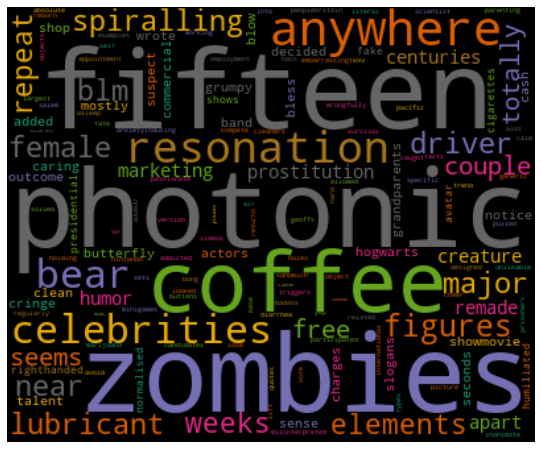

In [23]:
# Create a word cloud to visualize the popularity of words from the middle of the dataset
title_ = df.Title_Analysis.str.split(expand=True).stack().value_counts()
title_ = title_[1100:]

wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate_from_frequencies(title_)
plt.figure(figsize=(10,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### 3.2 Upvotes

In [24]:
df["Upvotes"].describe()

count      1203.000000
mean      10035.947631
std       20222.301371
min         224.000000
25%         407.500000
50%        1000.000000
75%        7000.000000
max      137000.000000
Name: Upvotes, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


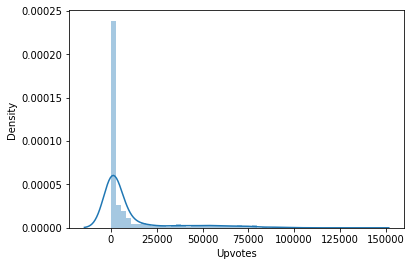

In [25]:
# The Upvotes are skewed with the lower upvotes being more popular, this could be fixed using either normalization or binning
g = sns.distplot(df["Upvotes"])

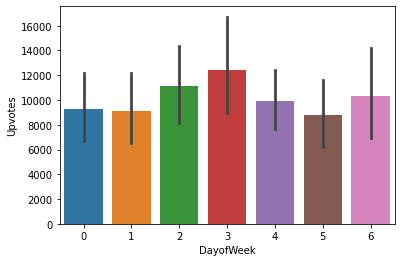

In [26]:
# The amount of upvotes from the Day of Week
g = sns.barplot(y="Upvotes",x="DayofWeek", data=df)

In [27]:
# Binning Upvotes into 3 parts
bands = [0, 500, 1000, 5000, 10000, 50000, 150000]
new_labels = [0,1,2,3,4,5]

df['Upvotes_Bin'] = df["Upvotes"]
df['Upvotes_Bin'] = pd.cut(df["Upvotes_Bin"], bins=bands, labels=new_labels)

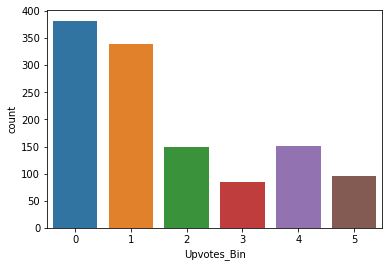

In [28]:
# The barplot of the binning of upvotes
g = sns.countplot(x="Upvotes_Bin", data=df)

### 3.3 DayofWeek

In [29]:
df["DayofWeek"].describe()

count    1203.000000
mean        2.940150
std         1.985742
min         0.000000
25%         1.000000
50%         3.000000
75%         5.000000
max         6.000000
Name: DayofWeek, dtype: float64

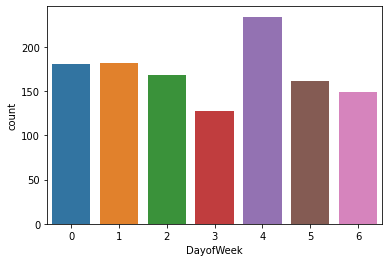

In [30]:
# How many of each day of week count there are
g = sns.countplot(x="DayofWeek", data=df)

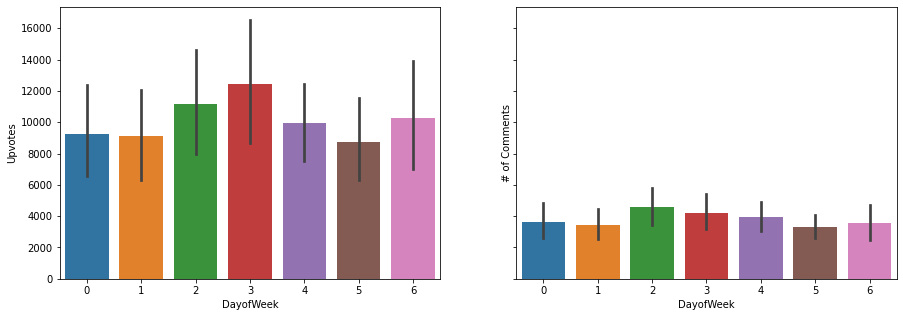

In [31]:
# Upvotes vs # of Comments to Day of Week.
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True,figsize=(15,5))
sns.barplot(x="DayofWeek", y="Upvotes", data=df,ax=ax1)
sns.barplot(x="DayofWeek", y="# of Comments", data=df,ax=ax2)

### 3.4 Number of Comments

In [32]:
df["# of Comments"].describe()

count     1203.000000
mean      3800.465503
std       6954.385719
min          3.000000
25%        637.000000
50%       1300.000000
75%       3200.000000
max      59600.000000
Name: # of Comments, dtype: float64

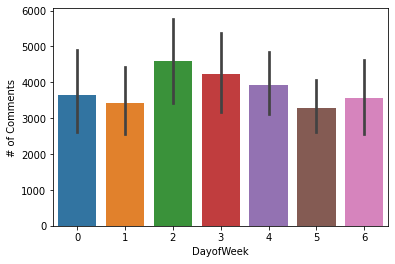

In [33]:
# The # of Comments on the Day of Week
g = sns.barplot(y="# of Comments",x="DayofWeek", data=df)

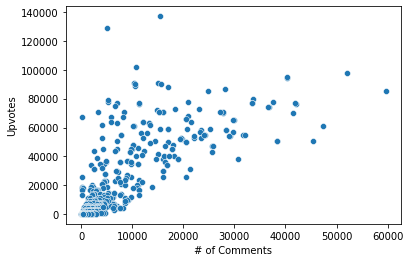

In [34]:
# Scatterplot from Upvotes vs # of Comments
g = sns.scatterplot(y="Upvotes",x="# of Comments", data=df)

## Classification Model

In [35]:
# Max number of words available
vocab_size = 10000
# The size of the numpy array based on the sentence
embedding_dim = 16
# Max length of how long a sentence can be
max_length = 20
# Start from the end of the sentence and leave the remainder a 0
trunc_type='post'
# Start from the end of the sentence and leave the remainder a 0
padding_type='post'
# Replace Unknown words in a test set into this string
oov_tok = "<OOV>"

In [36]:
# Initiate the Tensorflow's Tokenizer
tokenizer = Tokenizer(oov_token=oov_tok)

# Remove stop words
#stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
#df['Title'] = df['Title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

corpus = df["Title"]
# Create a list of words using the dataset's Title column
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

print(total_words)

2303


In [37]:
# Create a list of sequences using the tokenized words, example: [11, 14, 12, 13] = [hello, how, are, you]
sequences = tokenizer.texts_to_sequences(corpus)
padded = pad_sequences(sequences, maxlen=max_length,padding=padding_type, truncating=trunc_type)

# First transform the padded sequences to an numpy array for the model, and then change the labels into categorical features
np_padded = np.array(padded)
np_labels = to_categorical(df["Upvotes_Bin"])

In [38]:
# Create the Classification Model
model = tf.keras.Sequential([
    # Create a layer of multi dimensional embedding to categorize the tokenized words
    tf.keras.layers.Embedding(total_words, 100, input_length=max_length),
    # Create a layer of LSTM (Long Short Term Memory)
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # Create a layer of Dropout which randomly drops neurons to decrease overfitting
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    # Create a layer of neurons to the number of categories
    tf.keras.layers.Dense(6, activation='softmax')
])

adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 100)           230300    
_________________________________________________________________
bidirectional (Bidirectional (None, 20, 128)           84480     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 390       
Total params: 360,546
Trainable params: 360,546
Non-trainable params: 0
__________________________________________________

In [39]:
history = model.fit(np_padded, np_labels, epochs=15, verbose=1)
#print model.summary()
print(model)

Epoch 1/15
38/38 [==============================] - 1s 14ms/step - loss: 1.6685 - accuracy: 0.2909
Epoch 2/15
38/38 [==============================] - 1s 14ms/step - loss: 1.4671 - accuracy: 0.4057
Epoch 3/15
38/38 [==============================] - 1s 13ms/step - loss: 1.0698 - accuracy: 0.6451
Epoch 4/15
38/38 [==============================] - 1s 13ms/step - loss: 0.7103 - accuracy: 0.7631
Epoch 5/15
38/38 [==============================] - 1s 13ms/step - loss: 0.5031 - accuracy: 0.8628
Epoch 6/15
38/38 [==============================] - 1s 14ms/step - loss: 0.3492 - accuracy: 0.8986
Epoch 7/15
38/38 [==============================] - 1s 13ms/step - loss: 0.2425 - accuracy: 0.9343
Epoch 8/15
38/38 [==============================] - 1s 14ms/step - loss: 0.1327 - accuracy: 0.9626
Epoch 9/15
38/38 [==============================] - 0s 13ms/step - loss: 0.1146 - accuracy: 0.9701
Epoch 10/15
38/38 [==============================] - 1s 13ms/step - loss: 0.0964 - accuracy: 0.9709
Epoch 11/

In [40]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

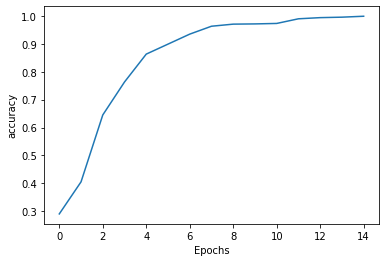

In [41]:
plot_graphs(history, 'accuracy')

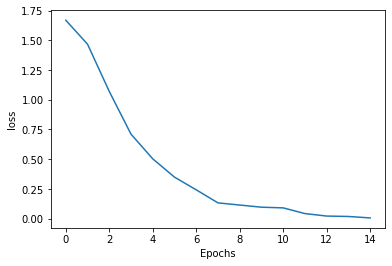

In [42]:
plot_graphs(history, 'loss')

In [43]:
# The question to predict
seed_text = ["What book have you read that has forever changed the way you view or live life?"]

# Create a tokenized question then pad it to sequence
token_list = tokenizer.texts_to_sequences(seed_text)
token_pad = pad_sequences(token_list, maxlen=max_length, padding='post')

# Predict the question using the trained model
yup = model.predict(token_pad)
# The numbers represent the categories and how high percentage the model thinks this question belongs to
print(yup)  

[[9.9999154e-01 2.8089992e-06 9.4463751e-08 3.4174383e-10 4.3768396e-06
  1.1176986e-06]]


In [44]:
#to_list = list(yup)
index_max = np.argmax(yup)
print(index_max)

print("This Comment should have Upvote between: %s-%s" % (bands[index_max], bands[index_max + 1]))

0
This Comment should have Upvote between: 0-500


## Generation Model

In [45]:
# Drop the upvotes in the dataset that are less than 3000 upvotes
df.drop(df.loc[df['Upvotes'] < 3000].index, inplace=True)

In [46]:
# initiate the Tensorflow's Tokenizer
tokenizer = Tokenizer()

corpus = df["Title"]
# Create a list of words using the dataset's Title column
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

print(tokenizer.word_index)
print(total_words)

{'you': 1, 'what': 2, 'the': 3, 'of': 4, 'your': 5, 'a': 6, 'to': 7, 'is': 8, 'do': 9, 'that': 10, 'and': 11, 'in': 12, 'would': 13, 'if': 14, 'are': 15, 'reddit': 16, 'how': 17, 'people': 18, 'was': 19, 'it': 20, 'have': 21, 'be': 22, 'for': 23, 'about': 24, 'most': 25, 'why': 26, 'but': 27, 'who': 28, 'thing': 29, 'on': 30, "what's": 31, 'with': 32, 'ever': 33, 'what’s': 34, 'from': 35, 'serious': 36, 'has': 37, 'did': 38, 'or': 39, 'one': 40, 'some': 41, 'get': 42, 'something': 43, 'could': 44, 'now': 45, 'right': 46, 'not': 47, 'were': 48, 'so': 49, 'at': 50, 'like': 51, 'still': 52, 'their': 53, 'can': 54, 'which': 55, 'as': 56, 'will': 57, 'made': 58, 'story': 59, 'someone': 60, 'find': 61, 'no': 62, 'up': 63, 'life': 64, 'best': 65, 'day': 66, 'when': 67, 'men': 68, 'movie': 69, 'things': 70, 'had': 71, 'time': 72, 'happened': 73, 'person': 74, 'game': 75, 'reason': 76, 'an': 77, 'we': 78, 'actually': 79, 'worst': 80, "you're": 81, 'out': 82, 'way': 83, 'been': 84, 'every': 85, 

In [47]:
input_sequences = []
for line in corpus:
	# Create a array of numbers from the sentences from the dataset's Title Column
	token_list = tokenizer.texts_to_sequences([line])[0]
	# Create a Numpy array from the sentence that leaves the last word from 
  # sentence as the label
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [48]:
# Create a Generation Model
model = Sequential()
# Create a layer of multi dimensional embedding to categorize the tokenized words
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
# Create a layer of LSTM (Long Short Term Memory)
model.add(Bidirectional(LSTM(150)))
# Create a layer of Dropout which randomly drops neurons to decrease overfitting
model.add(Dropout(0.3))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
#earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
model.fit(xs, ys, epochs=100, verbose=1)
#print model.summary()
print(model)


Epoch 1/100
172/172 [==============================] - 2s 12ms/step - loss: 6.0383 - accuracy: 0.0741
Epoch 2/100
172/172 [==============================] - 2s 11ms/step - loss: 4.9190 - accuracy: 0.1640
Epoch 3/100
172/172 [==============================] - 2s 12ms/step - loss: 3.7665 - accuracy: 0.2802
Epoch 4/100
172/172 [==============================] - 2s 11ms/step - loss: 2.7525 - accuracy: 0.4184
Epoch 5/100
172/172 [==============================] - 2s 11ms/step - loss: 2.0562 - accuracy: 0.5249
Epoch 6/100
172/172 [==============================] - 2s 11ms/step - loss: 1.6174 - accuracy: 0.6057
Epoch 7/100
172/172 [==============================] - 2s 11ms/step - loss: 1.2707 - accuracy: 0.6827
Epoch 8/100
172/172 [==============================] - 2s 11ms/step - loss: 1.1092 - accuracy: 0.7112
Epoch 9/100
172/172 [==============================] - 2s 12ms/step - loss: 0.9903 - accuracy: 0.7407
Epoch 10/100
172/172 [==============================] - 2s 12ms/step - loss: 0.957

In [49]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

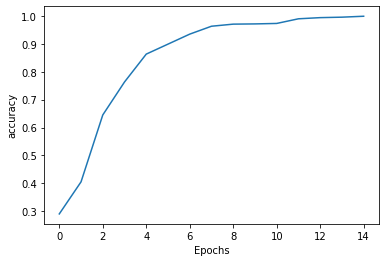

In [50]:
plot_graphs(history, 'accuracy')


In [51]:
# List of first word to generate the questions from
seed_list = ["what",'if','whats','people','you','how']
generation_list = []
next_words = 13

# Iterate through the seed_list to generate sentences
for i in seed_list:
	seed_text = ''
	seed_text += i
	for _ in range(next_words):
		# Continue to generate words using the current word as the feature
		# And the next word as the prediction
		token_list = tokenizer.texts_to_sequences([seed_text])[0]
		token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
		predicted = model.predict_classes(token_list, verbose=0)
		output_word = ""
		for word, index in tokenizer.word_index.items():
			if index == predicted:
				output_word = word
				break
		seed_text += " " + output_word
	generation_list.append(seed_text)
 
print(generation_list)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
['what is a scam not many people notice how would you describe your day', 'if you could enlarge one thing about your body what would you embiggen conversely', 'whats the single worst movie you sat through hoping it would get rid that', 'people who read the terms and conditions of you what is your reaction to', 'you have hacked donald trump’s twitter profile what’s the most damaging single tweet you', 'how do you piss off an entire fandom earlier of it is a recommend']
